# 케라스 전이 학습(Transfer Learning)

<img src="https://miro.medium.com/max/5252/1*Z11P-CjNYWBofEbmGQrptA.png">

<sub>출처: https://medium.com/the-official-integrate-ai-blog/transfer-learning-explained-7d275c1e34e2</sub>


In [1]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Flatten, BatchNormalization, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import *

In [2]:
vgg16 = VGG16(weights = 'imagenet', 
             input_shape = (32, 32, 3), include_top = False)

## include_top : 모델의 분류기층 포함 여부 / False로 분류기층 미포함 >> 직접 간소화된 모델 생성할 예정

In [3]:
model = Sequential()
model.add(vgg16)

model.add(Flatten())
model.add(Dense(256))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dense(10, activation = 'softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 1, 1, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 512)               0         
_________________________________________________________________
dense (Dense)                (None, 256)               131328    
_________________________________________________________________
batch_normalization (BatchNo (None, 256)               1024      
_________________________________________________________________
activation (Activation)      (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                2570      
Total params: 14,849,610
Trainable params: 14,849,098
Non-trainable params: 512
__________________________________________

In [ ]:
mobilenet = MobileNet(weights = None, input_shape = None, include_top = True)

resnet50 = ResNet50(weights = None, input_shape = None, include_top = True)

xception = Xception(weights = None, input_shape = None, include_top = True)

### 예제 : Dogs vs Cats
- Kaggle Data 이용: https://www.kaggle.com/c/dogs-vs-cats/data

- ImageDataGenerator의 flow_from_directory 이용

- 런타임 유형 GPU 사용

- 출처: https://colab.research.google.com/github/google/eng-edu/blob/master/ml/pc/exercises/image_classification_part2.ipynb#scrollTo=SdW6geEVi2S8

#### modules import

In [4]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import array_to_img, img_to_array, load_img, ImageDataGenerator
from tensorflow.keras.layers import Conv2D, Flatten, MaxPool2D, Input, Dropout, Dense
from tensorflow.keras import Model
from tensorflow.keras.optimizers import Adam

import os
import zipfile
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
plt.style.use('seaborn-white')

#### 데이터 로드

In [8]:
local_zip = 'C:\workspace\TIL\cats_and_dogs_filtered.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('C:\workspace\TIL\DL')
zip_ref.close()

In [9]:
base_dir = 'C:\workspace\TIL\DL\cats_and_dogs_filtered'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

In [10]:
train_cats_dir = os.path.join(train_dir, 'cats')

train_dogs_dir = os.path.join(train_dir, 'dogs')

validation_cats_dir = os.path.join(validation_dir, 'cats')

validation_dogs_dir = os.path.join(validation_dir, 'dogs')

train_cat_fnames = os.listdir(train_cats_dir)
train_dog_fnames = os.listdir(train_dogs_dir)

#### 이미지 보강된 데이터 확인

In [12]:
datagen = ImageDataGenerator(rotation_range = 40,
                            width_shift_range = 0.2,
                            height_shift_range = 0.2,
                             shear_range = 0.2,
                             zoom_range = 0.2, 
                             horizontal_flip = True,
                             fill_mode = 'nearest'
                            )

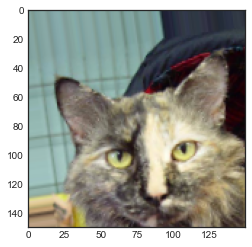

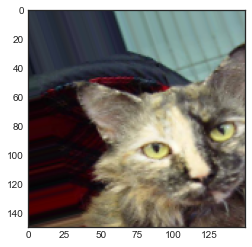

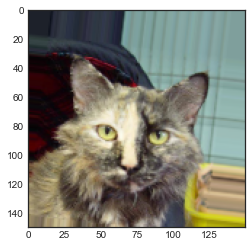

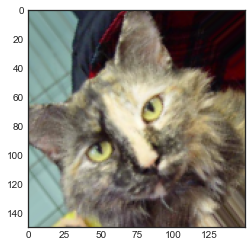

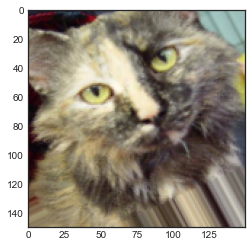

In [13]:
img_path = os.path.join(train_cats_dir, train_cat_fnames[2])
img = load_img(img_path, target_size = (150, 150))
# 이미지 배열로 전환
x = img_to_array(img)            ## (150, 150, 3)
x = x.reshape((1, ) + x.shape)   ## (1, 150, 150, 3)

i = 0
for batch in datagen.flow(x, batch_size = 1):
    plt.figure(i)
    imgplot = plt.imshow(array_to_img(batch[0]))
    i += 1
    if i % 5 == 0:
        break
        
### Generator를 통해 여러형태의 이미지로 변경이되었음

#### 학습, 검증 데이터셋의 Data Generator

In [14]:
train_datagen = ImageDataGenerator(rescale = 1./255,
                                  rotation_range = 40,
                                  width_shift_range = 0.2,
                                  height_shift_range = 0.2,
                                  shear_range = 0.2,
                                  zoom_range = 0.2,
                                  horizontal_flip = True)

train_generator = train_datagen.flow_from_directory(train_dir, target_size = (150, 150), 
                                                    batch_size = 20, class_mode = 'binary')

val_datagen = ImageDataGenerator(rescale = 1./255)

validation_generator = val_datagen.flow_from_directory(validation_dir, target_size = (150, 150),
                                                      batch_size = 20, class_mode = 'binary')

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


#### 모델 구성 및 컴파일

In [15]:
model = Sequential()
model.add(Conv2D(32, (3, 3), activation = 'relu', input_shape = (150, 150, 3)))
model.add(MaxPool2D(2, 2))
model.add(Conv2D(64, (3, 3), activation = 'relu'))
model.add(MaxPool2D(2, 2))
model.add(Conv2D(128, (3, 3), activation = 'relu'))
model.add(MaxPool2D(2, 2))
model.add(Conv2D(128, (3, 3), activation = 'relu'))
model.add(MaxPool2D(2, 2))
model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(512, activation = 'relu'))
model.add(Dense(1, activation = 'sigmoid'))       ## 'binary'이므로 최종 output값은 1로 출력되어야함

model.compile(loss = 'binary_crossentropy',
             optimizer = Adam(learning_rate = 1e-4),
             metrics = ['acc'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 15, 15, 128)      

#### 모델 학습 및 학습 과정 시각화
- 런타임유형 GPU 사용

In [16]:
history = model.fit(train_generator, 
                    steps_per_epoch = 100,
                    epochs = 30,
                    batch_size = 256,
                    validation_data = validation_generator,
                    validation_steps = 50,
                    verbose = 2
                   )

Epoch 1/30
100/100 - 35s - loss: 0.6933 - acc: 0.5105 - val_loss: 0.6907 - val_acc: 0.5000
Epoch 2/30
100/100 - 14s - loss: 0.6862 - acc: 0.5505 - val_loss: 0.6752 - val_acc: 0.5260
Epoch 3/30
100/100 - 14s - loss: 0.6712 - acc: 0.5810 - val_loss: 0.6829 - val_acc: 0.5390
Epoch 4/30
100/100 - 15s - loss: 0.6504 - acc: 0.6285 - val_loss: 0.6369 - val_acc: 0.6090
Epoch 5/30
100/100 - 15s - loss: 0.6323 - acc: 0.6385 - val_loss: 0.5941 - val_acc: 0.6770
Epoch 6/30
100/100 - 15s - loss: 0.6132 - acc: 0.6560 - val_loss: 0.6109 - val_acc: 0.6700
Epoch 7/30
100/100 - 15s - loss: 0.6054 - acc: 0.6710 - val_loss: 0.5805 - val_acc: 0.6880
Epoch 8/30
100/100 - 15s - loss: 0.5922 - acc: 0.6815 - val_loss: 0.5513 - val_acc: 0.7100
Epoch 9/30
100/100 - 15s - loss: 0.5869 - acc: 0.6945 - val_loss: 0.5401 - val_acc: 0.7150
Epoch 10/30
100/100 - 15s - loss: 0.5798 - acc: 0.6865 - val_loss: 0.5437 - val_acc: 0.7210
Epoch 11/30
100/100 - 15s - loss: 0.5892 - acc: 0.6785 - val_loss: 0.5357 - val_acc: 0.72

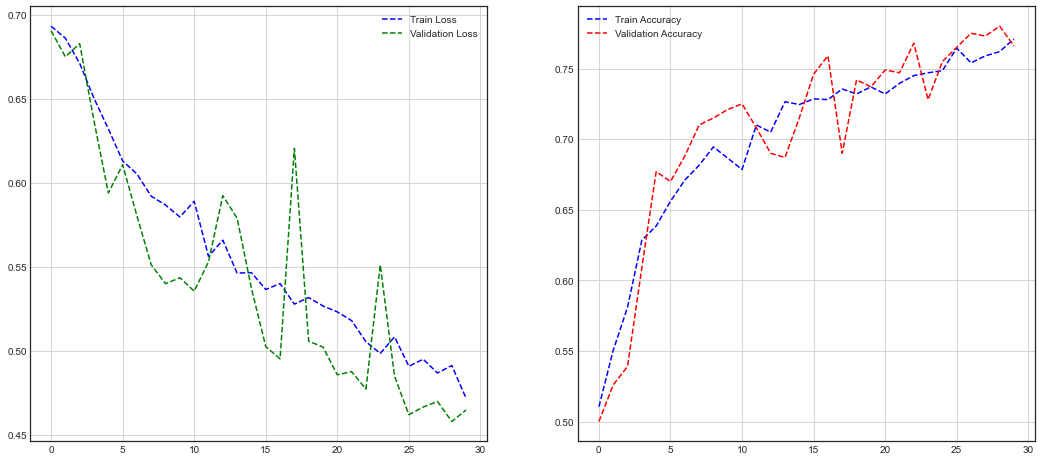

In [19]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.figure(figsize = (18, 8))

plt.subplot(1, 2, 1)
plt.plot(epochs, loss, 'b--', label = 'Train Loss')
plt.plot(epochs, val_loss, 'g--', label = 'Validation Loss')
plt.grid()
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, acc, 'b--', label = 'Train Accuracy')
plt.plot(epochs, val_acc, 'r--', label = 'Validation Accuracy')
plt.grid()
plt.legend()

plt.show()

#### 모델 저장

In [20]:
model.save('cats_and_dogs_model.h5')

### 사전 훈련된 모델 사용

In [21]:
conv_base = VGG16(weights = 'imagenet',
                 input_shape = (150, 150, 3), include_top = False)

In [22]:
from tensorflow.keras.optimizers import RMSprop

def build_model_with_pretrained(conv_base):
    model = Sequential()
    model.add(conv_base)
    model.add(Flatten())
    model.add(Dense(256, activation = 'relu'))
    model.add(Dense(1, activation = 'sigmoid'))
    
    model.compile(loss = 'binary_crossentropy',
                 optimizer = RMSprop(learning_rate = 2e-5),
                 metrics = ['acc'])
    
    return model

파라미터의 수 확인!

In [23]:
model = build_model_with_pretrained(conv_base)
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_2 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 256)               2097408   
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 257       
Total params: 16,812,353
Trainable params: 16,812,353
Non-trainable params: 0
_________________________________________________________________


#### 레이어 동결
- 훈련하기 전, 합성곱 기반 레이어들의 가중치 학습을 막기 위해 이를 동결

In [24]:
print(len(model.trainable_weights))

30


In [25]:
conv_base.trainable = False
print(len(model.trainable_weights))

4


#### 모델 컴파일
- trainable 속성을 변경했기 때문에 다시 모델을 컴파일 해야함

In [26]:
model.compile(loss = 'binary_crossentropy',
                 optimizer = Adam(learning_rate = 2e-5),
                 metrics = ['acc'])

#### 이미지 제너레이터

In [27]:
train_datagen = ImageDataGenerator(rescale = 1./255,
                                  rotation_range = 40,
                                  width_shift_range = 0.2,
                                  height_shift_range = 0.2,
                                  shear_range = 0.2,
                                  zoom_range = 0.2,
                                  horizontal_flip = True)

train_generator = train_datagen.flow_from_directory(train_dir, target_size = (150, 150), 
                                                    batch_size = 20, class_mode = 'binary')

val_datagen = ImageDataGenerator(rescale = 1./255)

validation_generator = val_datagen.flow_from_directory(validation_dir, target_size = (150, 150),
                                                      batch_size = 20, class_mode = 'binary')

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


#### 모델 재학습

In [28]:
history2 = model.fit(train_generator, 
                    steps_per_epoch = 100,
                    epochs = 30,
                    batch_size = 256,
                    validation_data = validation_generator,
                    validation_steps = 50,
                    verbose = 2
                   )

Epoch 1/30
100/100 - 18s - loss: 0.5884 - acc: 0.7095 - val_loss: 0.4444 - val_acc: 0.8300
Epoch 2/30
100/100 - 15s - loss: 0.4737 - acc: 0.7960 - val_loss: 0.3752 - val_acc: 0.8410
Epoch 3/30
100/100 - 15s - loss: 0.4312 - acc: 0.8210 - val_loss: 0.3450 - val_acc: 0.8480
Epoch 4/30
100/100 - 15s - loss: 0.4011 - acc: 0.8245 - val_loss: 0.3226 - val_acc: 0.8600
Epoch 5/30
100/100 - 15s - loss: 0.3787 - acc: 0.8360 - val_loss: 0.3137 - val_acc: 0.8640
Epoch 6/30
100/100 - 16s - loss: 0.3732 - acc: 0.8345 - val_loss: 0.2977 - val_acc: 0.8710
Epoch 7/30
100/100 - 15s - loss: 0.3503 - acc: 0.8420 - val_loss: 0.2880 - val_acc: 0.8770
Epoch 8/30
100/100 - 15s - loss: 0.3487 - acc: 0.8515 - val_loss: 0.2813 - val_acc: 0.8780
Epoch 9/30
100/100 - 15s - loss: 0.3390 - acc: 0.8550 - val_loss: 0.2765 - val_acc: 0.8820
Epoch 10/30
100/100 - 15s - loss: 0.3411 - acc: 0.8515 - val_loss: 0.2878 - val_acc: 0.8790
Epoch 11/30
100/100 - 16s - loss: 0.3372 - acc: 0.8540 - val_loss: 0.2730 - val_acc: 0.88

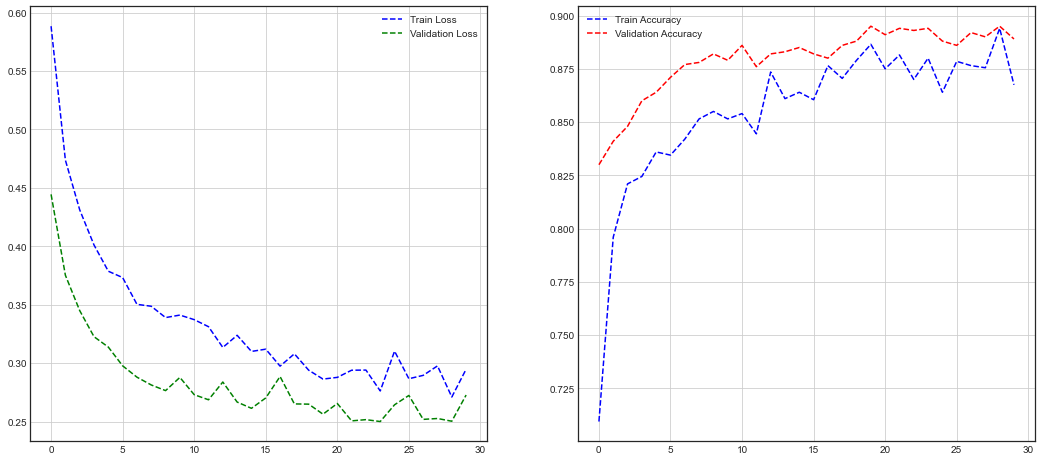

In [29]:
# 시각화

acc = history2.history['acc']
val_acc = history2.history['val_acc']
loss = history2.history['loss']
val_loss = history2.history['val_loss']

epochs = range(len(acc))

plt.figure(figsize = (18, 8))

plt.subplot(1, 2, 1)
plt.plot(epochs, loss, 'b--', label = 'Train Loss')
plt.plot(epochs, val_loss, 'g--', label = 'Validation Loss')
plt.grid()
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, acc, 'b--', label = 'Train Accuracy')
plt.plot(epochs, val_acc, 'r--', label = 'Validation Accuracy')
plt.grid()
plt.legend()

plt.show()

#### 모델 저장

In [30]:
model.save('cats_and_dogs_with_pretrained_model.h5')

## Feature Map 시각화

In [31]:
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
import numpy as np

### 모델 구성

In [32]:
model = load_model('C:\workspace\TIL\DL\Keras\cats_and_dogs_model.h5')
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 15, 15, 128)      

In [36]:
img_path = 'C:/workspace/TIL/DL/cats_and_dogs_filtered/validation/dogs/dog.2000.jpg'

img = image.load_img(img_path, target_size = (150, 150))
img_tensor = image.img_to_array(img)
img_tensor = img_tensor[np.newaxis, ...]
img_tensor /= 255.
print(img_tensor.shape)

(1, 150, 150, 3)


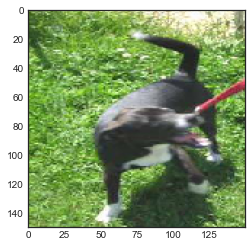

In [37]:
plt.imshow(img_tensor[0])
plt.show()

In [38]:
conv_output = [layer.output for layer in model.layers[:8]]
conv_output

[<KerasTensor: shape=(None, 148, 148, 32) dtype=float32 (created by layer 'conv2d')>,
 <KerasTensor: shape=(None, 74, 74, 32) dtype=float32 (created by layer 'max_pooling2d')>,
 <KerasTensor: shape=(None, 72, 72, 64) dtype=float32 (created by layer 'conv2d_1')>,
 <KerasTensor: shape=(None, 36, 36, 64) dtype=float32 (created by layer 'max_pooling2d_1')>,
 <KerasTensor: shape=(None, 34, 34, 128) dtype=float32 (created by layer 'conv2d_2')>,
 <KerasTensor: shape=(None, 17, 17, 128) dtype=float32 (created by layer 'max_pooling2d_2')>,
 <KerasTensor: shape=(None, 15, 15, 128) dtype=float32 (created by layer 'conv2d_3')>,
 <KerasTensor: shape=(None, 7, 7, 128) dtype=float32 (created by layer 'max_pooling2d_3')>]

In [39]:
activation_model = Model(inputs = [model.input], outputs = conv_output)

In [40]:
activations = activation_model.predict(img_tensor)

In [41]:
len(activations)

8

### 시각화

(1, 148, 148, 32)


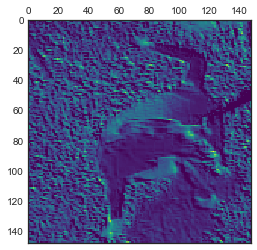

In [46]:
print(activations[0].shape)
plt.matshow(activations[0][0, :, :, 1], cmap = 'viridis')
plt.show()

(1, 148, 148, 32)


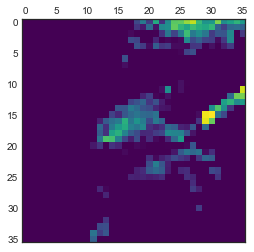

In [58]:
print(activations[0].shape)
plt.matshow(activations[3][0, :, :, 20], cmap = 'viridis')
plt.show()

### 중간의 모든 활성화에 대해 시각화

<ipython-input-61-d775b58fafd0>:19: RuntimeWarning: invalid value encountered in true_divide
  channel_image /= channel_image.std()


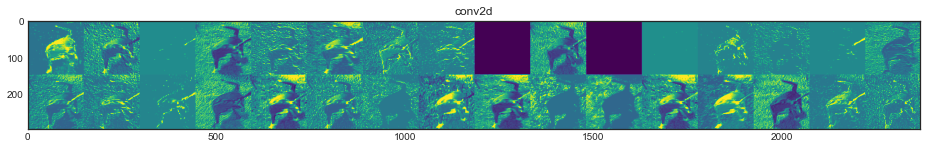

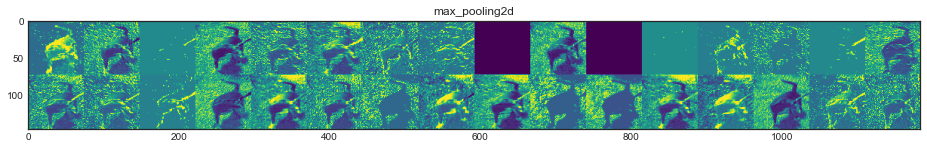

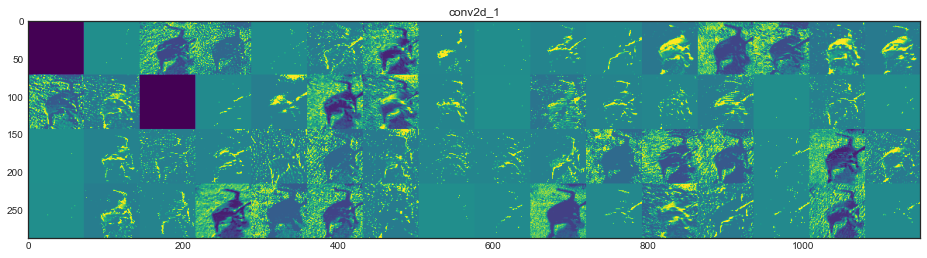

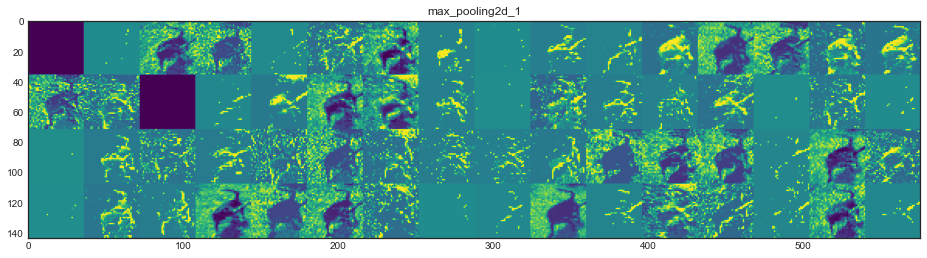

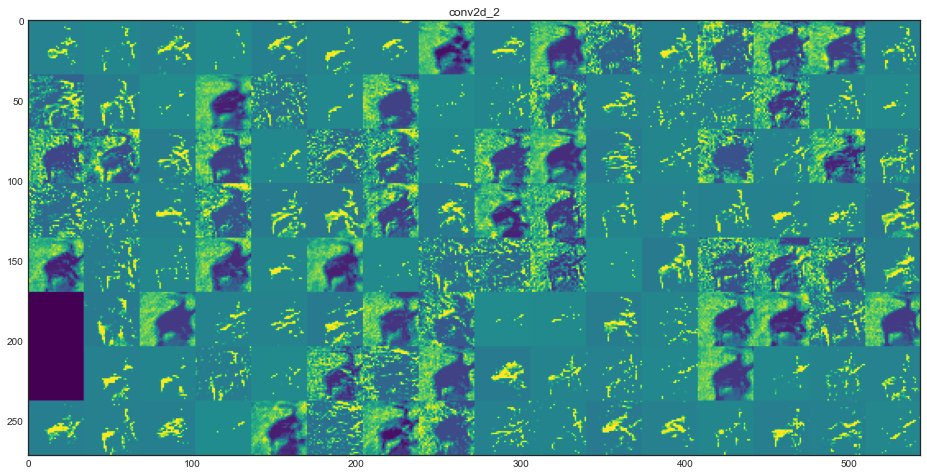

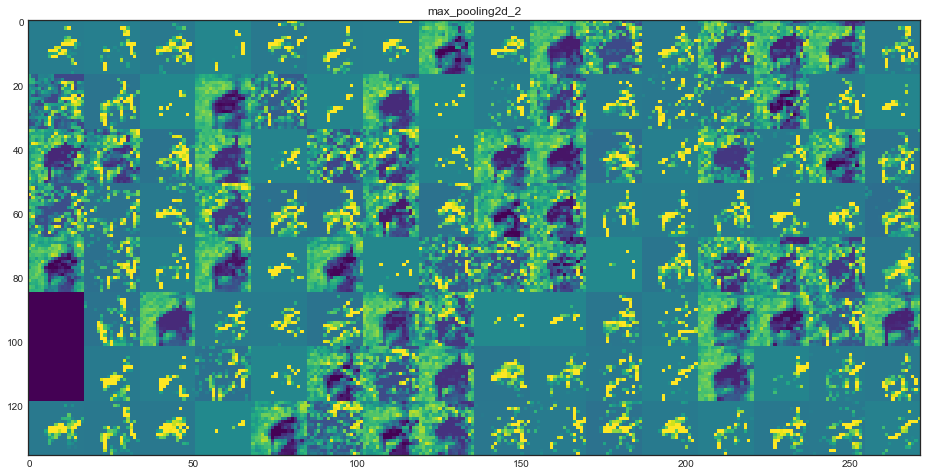

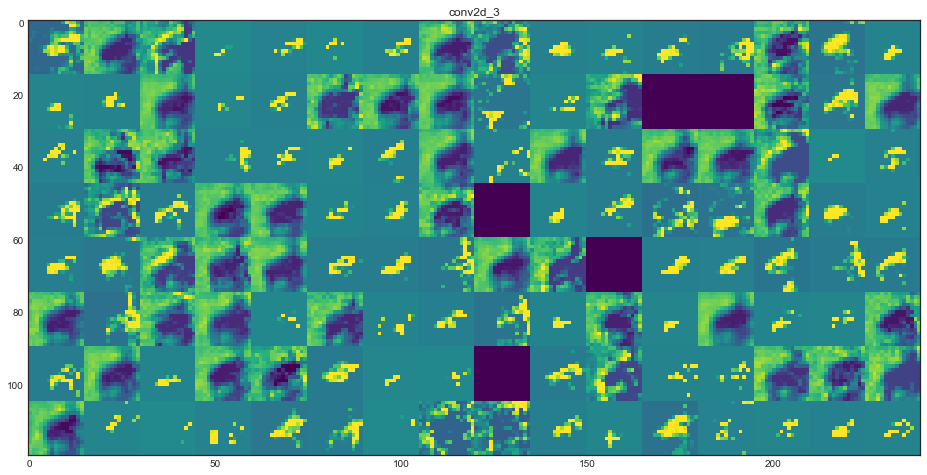

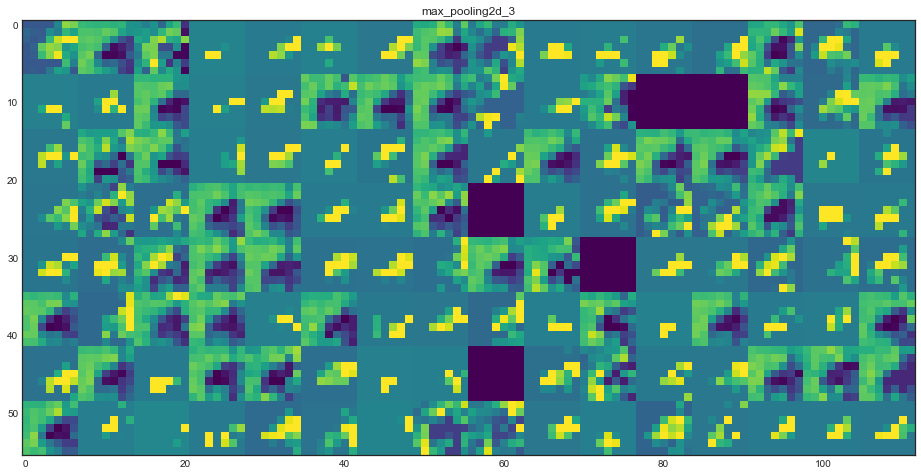

In [61]:
layer_names = []
for layer in model.layers[:8]:
    layer_names.append(layer.name)
    
images_per_row = 16

for layer_name, layer_activation in zip(layer_names, activations):
    num_features = layer_activation.shape[-1]
    
    size = layer_activation.shape[1]
    
    num_cols = num_features // images_per_row
    display_grid = np.zeros((size * num_cols, images_per_row * size))
    
    for col in range(num_cols):
        for row in range(images_per_row):
            channel_image = layer_activation[0, :, :, col * images_per_row + row]
            channel_image -= channel_image.mean()
            channel_image /= channel_image.std()
            channel_image *= 64
            channel_image += 128
            channel_image = np.clip(channel_image, 0, 255).astype('uint8')
            display_grid[col * size: (col+1) * size, row * size : (row+1) * size] = channel_image
            
    scale = 1. / size
    
    plt.figure(figsize = (scale * display_grid.shape[1], scale * display_grid.shape[0]))
    
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect = 'auto', cmap = 'viridis')
    
plt.show()